In [12]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras_ocr

In [13]:
ID = 'HDSRM300'

# get scale

In [48]:
# Open the PNG image
scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))

# Convert the image to grayscale
gs_scale_image = scale_image.convert("L")

# Convert the grayscale image to a NumPy array
grayscale_array = np.array(gs_scale_image)

# Define unique scale values
def get_scale(array):
    array = np.array([x[0] for x in array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)
    return scale

scale = get_scale(grayscale_array)

# get efficiency map

In [ ]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)
    
em = infill_text(ID)
plt.imshow(em)

In [ ]:
im = inpaint_text(os.path.join('inputs\efficiency_maps', ID +'.png'), pipeline)
cv2.imshow(im)

In [49]:
# Open the PNG image
efficiency_map_image = Image.open(os.path.join('inputs\efficiency_maps', ID +'.png'))

# Convert the image to grayscale
gs_efficiency_map_image = efficiency_map_image.convert("L")

# Convert the grayscale image to a NumPy array
grayscale_array = np.array(gs_efficiency_map_image)

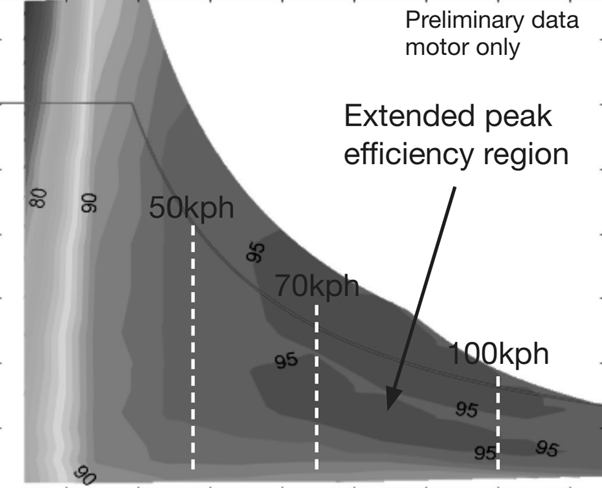

In [50]:
gs_efficiency_map_image

In [51]:



# Interpolate values in the grayscale array using the specified array
interpolated_array = np.interp(grayscale_array, scale, scale)

# Display the interpolated grayscale image as an array
print(interpolated_array)


[[53. 53. 53. ... 53. 53. 53.]
 [53. 53. 53. ... 53. 53. 53.]
 [53. 53. 53. ... 53. 53. 53.]
 ...
 [53. 53. 53. ... 53. 53. 53.]
 [53. 53. 53. ... 53. 53. 53.]
 [53. 53. 53. ... 53. 53. 53.]]


In [52]:
interpolated_array.shape

(488, 602)

In [53]:
grayscale_array

array([[253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [253, 253, 253, ..., 253, 253, 253]], dtype=uint8)

In [67]:
# Read the grayscale image
image = cv2.imread("grayscale_image.png", cv2.IMREAD_GRAYSCALE)

# Specify the array containing valid grayscale values
lookup_array = np.append(scale,255)

# Create a mask to identify pixels not in the lookup array
mask = np.isin(image, lookup_array, invert=True)

# Inpaint the image using the mask
inpaint = cv2.inpaint(image, mask.astype(np.uint8), inpaintRadius=10000, flags=cv2.INPAINT_TELEA)

# Display the original image and the inpainted image
cv2.imshow("Original Image", image)
cv2.imshow("Inpainted Image", inpaint)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [71]:
import cv2
import numpy as np

# Read the grayscale image
image = cv2.imread("grayscale_image.png", cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a mask for text regions
_, mask = cv2.threshold(image, 254, 255, cv2.THRESH_BINARY_INV)

# Inpaint the image to remove text
inpaint = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Display the original image and the inpainted image
cv2.imshow("Original Image", image)
cv2.imshow("Inpainted Image", inpaint)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [60]:
gs_efficiency_map_image.save("grayscale_image.png")

# Read the grayscale image
image = cv2.imread("grayscale_image.png", cv2.IMREAD_GRAYSCALE)

# Threshold the image to create a binary mask (adjust threshold as needed)
_, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)

# Apply morphological operations to remove small noise and connect nearby lines
kernel = np.ones((5, 5), np.uint8)
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Inpaint the image to remove text and lines
inpaint = cv2.inpaint(image, morph, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Display the original image and the processed image
cv2.imshow("Original Image", image)
cv2.imshow("Processed Image", inpaint)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)
pipeline = keras_ocr.pipeline.Pipeline()
def inpaint_text(img_path, pipeline):
    # read image
    img = keras_ocr.tools.read(img_path)
    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                 
    return(img)

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5

Instructions for updating:
Use `tf.image.resize(...method=ResizeMethod.BILINEAR...)` instead.

Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5


1/1 [==============================] - 3s 3s/step


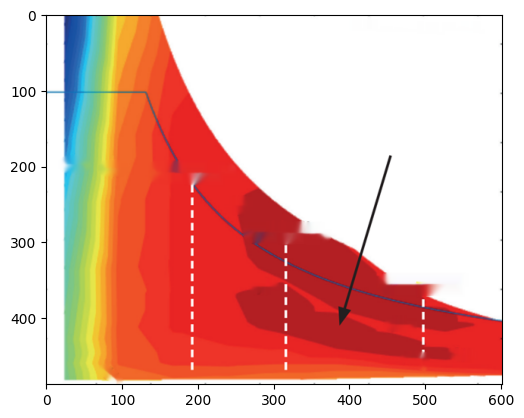

In [14]:
im = inpaint_text(os.path.join('inputs\efficiency_maps', ID +'.png'), pipeline)
cv2.imshow(im)